### [Stock Prediction with Attention-Based LSTM, RNN, and CNN](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

In recent years, advanced machine learning models such as **_Convolutional Neural Networks (CNNs)_**, **_Recurrent Neural Networks (RNNs)_** and their variants like **_Long Short-Term Memory (LSTM)_** have attracted considerable attention. These models leverage their ability to learn from historical data without requiring predefined equations, making them ideal to uncover hidden relationships and dependencies. They model financial data as a multidimensional problem, enabling more accurate and robust predictions.


Explore the application of CNNs, RNNs, and attention-based LSTM to predict **Tesla** stock prices.

In [1]:
!pip install -q numpy pandas yfinance matplotlib seaborn scikit-learn
!pip install -q keras "tensorflow==2.18.0"

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

def fetch_tesla_stock_data():
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = "TSLA"
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    tesla = yf.download(ticker, start=start_date, end=end_date)

    tesla['AdjClose'] = tesla['Close']

    # Return a DataFrame with the adjusted close prices
    tesla_data = tesla[['AdjClose']].rename(columns={"AdjClose": "adjClose"})
    tesla_data.index.name = "date"
    
    return tesla_data

In [4]:
# Fetch Tesla stock data
tesla_data = fetch_tesla_stock_data()

# Display the first few rows of data
print(tesla_data.head(10))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price       adjClose
Ticker              
date                
2010-06-29  1.592667
2010-06-30  1.588667
2010-07-01  1.464000
2010-07-02  1.280000
2010-07-06  1.074000
2010-07-07  1.053333
2010-07-08  1.164000
2010-07-09  1.160000
2010-07-12  1.136667
2010-07-13  1.209333


In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Define the window size and prediction time
window_size = 20
prediction_steps = 10

# Function to create sequences
def create_sequences(data, window_size, prediction_steps):
    X = []
    y = []
    
    for i in range(window_size, len(data) - prediction_steps):
        X.append(data[i-window_size:i, 0]) # input sequence
        y.append(data[i+prediction_steps-1, 0]) # target value (price at the next timestep)
    
    return np.array(X), np.array(y)

In [6]:
# Fetch Tesla stock data
data = tesla_data[['adjClose']].values

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for the model
X, y = create_sequences(scaled_data, window_size, prediction_steps)

# Reshape input data to be in the shape [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2873, 20, 1)
Testing data shape: (719, 20, 1)


#### LSTM stock prediction with attention

This model incorporates a custom attention layer to enhance its ability to capture key temporal patterns in Tesla stock prices. The model comprises of 50 units to preprocess the input sequences and retains significant temporal dependencies through its internal memory mechanisms.


Epoch 1/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0219 - val_loss: 0.0083
Epoch 2/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - val_loss: 0.0095
Epoch 3/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_loss: 0.0077
Epoch 4/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0083
Epoch 5/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0017 - val_loss: 0.0080
Epoch 6/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0095
Epoch 7/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0160
Epoch 8/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0018 - val_loss: 0.0074
Epoch 9/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0016 - val_loss: 0.0079
Epoch 10/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 11/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 12/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.

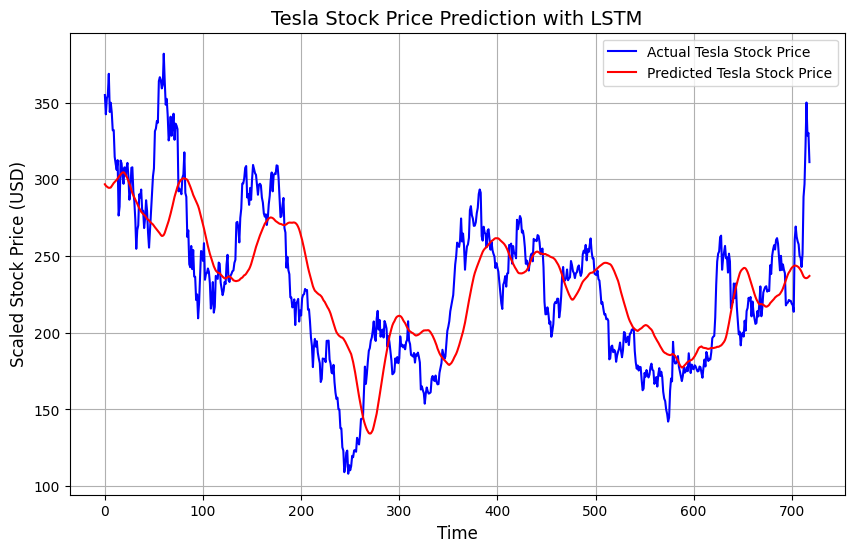

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Attention, Add, LayerNormalization, Layer
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)
        a = tf.matmul(q, inputs, transpose_b=True)
        attention_weights = tf.nn.softmax(a, axis=-1)
        return tf.matmul(attention_weights, inputs)

# LSTM model with attention and early stopping
def build_lstm_model_with_attention(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Attention layer
    model.add(AttentionLayer())
    model.add(LayerNormalization())
    
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


# Build the LSTM model with attention
model = build_lstm_model_with_attention(X_train.shape[1:])

# Implement EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with EarlyStopping and 50 epochs
history = model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Inverse scale the actual stock prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_scaled, predicted_stock_price)
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color='blue')
plt.plot(predicted_stock_price, label="Predicted Tesla Stock Price", color='red')
plt.title('Tesla Stock Price Prediction with LSTM', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Scaled Stock Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### Recurrent Neural Network (RNN)

Integrate an RNN to examine whether it would capture the temporal dependencies.

Epoch 1/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0213 - val_loss: 0.0052
Epoch 2/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 3/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 4/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0051
Epoch 5/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0026 - val_loss: 0.0062
Epoch 6/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0089
Epoch 7/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0051
Epoch 8/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0013 - val_loss: 0.0051
Epoch 9/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 10/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0089
Epoch 11/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 12/70
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_l

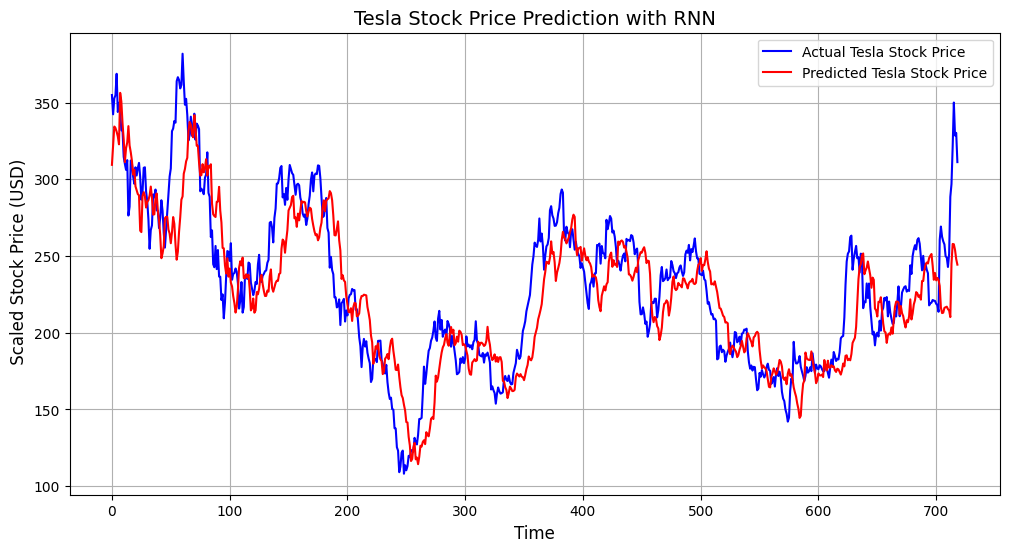

In [8]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

# Define the RNN model
def build_rnn_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build the RNN model
rnn_model = build_rnn_model(X_train.shape[1:])

# Train the model
rnn_history = rnn_model.fit(X_train, y_train, epochs=70, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
predicted_stock_price_rnn = rnn_model.predict(X_test)
predicted_stock_price_rnn = scaler.inverse_transform(predicted_stock_price_rnn)

# Inverse scale the actual stock prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE for RNN
mape_rnn = mean_absolute_percentage_error(y_test_scaled, predicted_stock_price_rnn)
print(f"Mean Absolute Percentage Error (MAPE) for RNN: {mape_rnn:.2f}%")
# Plot the results for RNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color='blue')
plt.plot(predicted_stock_price_rnn, label="Predicted Tesla Stock Price", color='red')
plt.title('Tesla Stock Price Prediction with RNN', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel(' Scaled Stock Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### Convoluted Neural Network (CNN)

The model is structured to automatically learn spatial hierarchies and patterns in the data.

- Apply several convolutional layers that use filters to detect important features in the input data.
- Use pooling layers to reduce dimensionality of the feature maps and retain the most significant information

Epoch 1/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.5662 - val_loss: 0.2120 - learning_rate: 0.0010
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1993 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1296 - val_loss: 0.1280 - learning_rate: 0.0010
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1024 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0699 - val_loss: 0.0962 - learning_rate: 0.0010
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0447 - val_loss: 0.0741 - learning_rate: 0.0010
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0379 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0304 - val_loss: 0.0568 - learning_rate: 0.0010
Epoch 9/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0233 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 10/200
90/90 

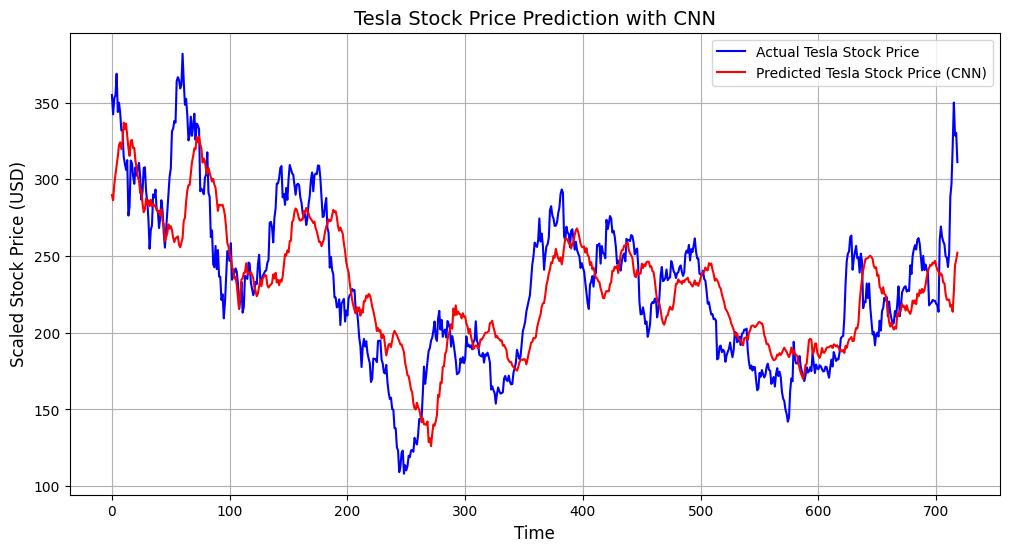

In [9]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    # Change pool_size to avoid reducing dimensions to zero
    model.add(MaxPooling1D(pool_size=2))
    
    # Add a condition to avoid further reduction if dimensions are too small
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=1))  # Adjusted pool size
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(units=100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for prediction

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


cnn_model = build_cnn_model(X_train.shape[1:])
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

cnn_history = cnn_model.fit(
    X_train, y_train, 
    epochs=200, 
    batch_size=32, 
    validation_data=(X_test, y_test), 
    callbacks=[early_stopping, reduce_lr]
)


# Build the CNN model
cnn_model = build_cnn_model(X_train.shape[1:])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model with early stopping and 100 epochs
cnn_history = cnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
predicted_stock_price_cnn = cnn_model.predict(X_test)
predicted_stock_price_cnn = scaler.inverse_transform(predicted_stock_price_cnn)

# Inverse scale the actual stock prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAPE for CNN
mape_cnn = mean_absolute_percentage_error(y_test_scaled, predicted_stock_price_cnn)
print(f"Mean Absolute Percentage Error (MAPE) for CNN: {mape_cnn:.2f}%")

# Plot the results for CNN model
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label="Actual Tesla Stock Price", color='blue')
plt.plot(predicted_stock_price_cnn, label="Predicted Tesla Stock Price (CNN)", color='red')
plt.title('Tesla Stock Price Prediction with CNN', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Scaled Stock Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### MAPE (Mean Absolute Percentage Error)

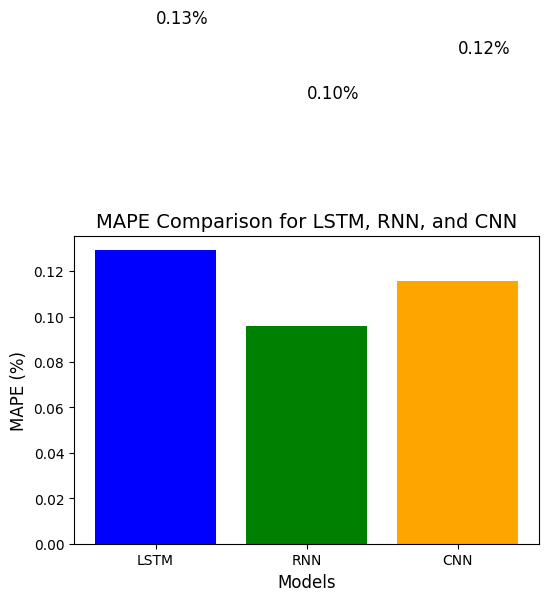

In [10]:
import matplotlib.pyplot as plt

mape_scores = [mape, mape_rnn, mape_cnn]
models = ['LSTM', 'RNN', 'CNN']

# Create the bar chart
plt.figure(figsize=(6, 4))
plt.bar(models, mape_scores, color=['blue', 'green', 'orange'])

# Add labels and title
plt.title('MAPE Comparison for LSTM, RNN, and CNN', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)

# Show the MAPE values on top of the bars
for i, v in enumerate(mape_scores):
    plt.text(i, v + 0.1, f'{v:.2f}%', fontsize=12)

# Display the plot
plt.show()